In [589]:
# imports
import igl
import meshplot as mp
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import surf
from skimage.metrics import structural_similarity as ssim

In [590]:
# define metrics for comparing operators
def squared_difference(x, y):
    return np.square(x - y)

def percentage_difference(x, y):
    return np.abs((x-y / y) * 100)

In [591]:
# load surface
surface_name = '/home/ibmeuser/Documents/Data/hcp-asl/HCP_asl_min_req_mean_16_onsurface/HCA6002236/T1w/fsaverage_LR32k/HCA6002236_V1_MR.L.midthickness.32k_fs_LR.surf.gii'
surface = nb.load(surface_name)
v, f = surface.agg_data()

In [592]:
# plot surface using meshplot
mp.jupyter()
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-28.24949…

In [593]:
# evaluate function at each vertex
function = 'sumsincos'
s = 4
u = surf.functions.FUNCS[function](v, s)
mp.plot(v, f, u)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-28.24949…

In [594]:
# get analytic curvature
an_curv = surf.curvatures.analytic_curvature(v, function, s)
curv_min, curv_max = [an_curv.min(), an_curv.max()]
print(f"Min curvature:{curv_min}")
print(f"Max curvature:{curv_max}")

Min curvature:-31.99759292602539
Max curvature:31.996185302734375


In [595]:
# get LBO of surface and apply to function
lbo = surf.testing_igl.get_lbo(v, f, area_type='voronoi')
lbo_u = lbo.dot(u)
clipped_lbo_u = np.clip(lbo_u, curv_min, curv_max)

In [596]:
# get curvature via the graph laplacian
gl = surf.testing_igl.get_graph_laplacian(f)
gl_u = gl.dot(u)
clipped_gl_u = np.clip(gl_u, curv_min, curv_max)

/home/ibmeuser/anaconda3/envs/igl/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [597]:
# plot the 3 curvatures for comparison
curv_plots = mp.subplot(v, f, c=an_curv, s=[1, 3, 0])
mp.subplot(v, f, c=lbo_u, s=[1, 3, 1], data=curv_plots)
mp.subplot(v, f, c=gl_u, s=[1, 3, 2], data=curv_plots)

In [598]:
# plot the difference between analytic and estimated curvature
sq_diff_lbo = squared_difference(lbo_u, an_curv)
mean_sq_diff = sq_diff_lbo.mean()
std_sq_diff = sq_diff_lbo.std()
print(f"Mean squared difference = {mean_sq_diff}")
print(f"S.D. of squared difference = {std_sq_diff}")
clipped_sq_diff_lbo = np.clip(sq_diff_lbo, 0, mean_sq_diff + 2*std_sq_diff)
perc_diff_lbo = percentage_difference(lbo_u, an_curv)
perc_max = 200
clipped_perc_diff_lbo = np.clip(perc_diff_lbo, 0, perc_max)

Mean squared difference = 198.2261505126953
S.D. of squared difference = 251.97157287597656


In [599]:
# get difference between analytic and gl-estimated curvature
sq_diff_gl = squared_difference(an_curv, gl_u)
clipped_sq_diff_gl = np.clip(sq_diff_gl, 0, mean_sq_diff + 2*std_sq_diff)
perc_diff_gl = percentage_difference(gl_u, an_curv)
clipped_perc_diff_gl = np.clip(perc_diff_gl, 0, perc_max)

In [600]:
# plot squared differences
sq_diff_plots = mp.subplot(v, f, c=clipped_sq_diff_lbo, s=[1, 2, 0])
mp.subplot(v, f, c=clipped_sq_diff_gl, s=[1, 3, 1], data=sq_diff_plots)

In [601]:
# plot percentage differences
perc_diff_plots = mp.subplot(v, f, c=clipped_perc_diff_lbo, s=[1, 2, 0])
mp.subplot(v, f, c=clipped_perc_diff_gl, s=[1, 3, 1], data=perc_diff_plots)

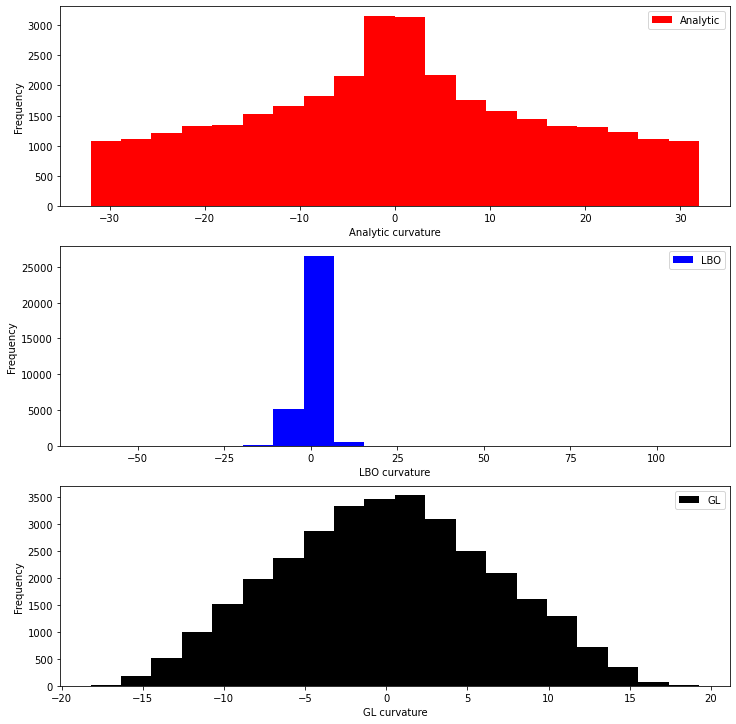

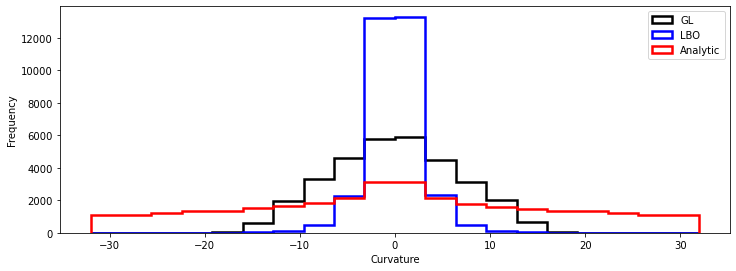

In [602]:
# show histograms of raw values
nbins = 20
colours = ('r', 'b', 'k')
labels = ('Analytic', 'LBO', 'GL')
fig, axs = plt.subplots(3, 1, figsize=(12, 12.5))
for ax, label, curv, colour in zip(axs, labels, (an_curv, lbo_u, gl_u), colours):
    ax.hist(curv, nbins, color=colour, label=label)
    ax.set_xlabel(f"{label} curvature")
    ax.set_ylabel("Frequency")
    ax.legend()

fig, ax = plt.subplots(figsize=(12, 12.5/3))
ax.hist((an_curv, clipped_lbo_u, clipped_gl_u), nbins, color=colours, label=labels, histtype='step', stacked=False, fill=False, linewidth=2.5)
ax.set_xlabel("Curvature")
ax.set_ylabel("Frequency")
ax.legend()

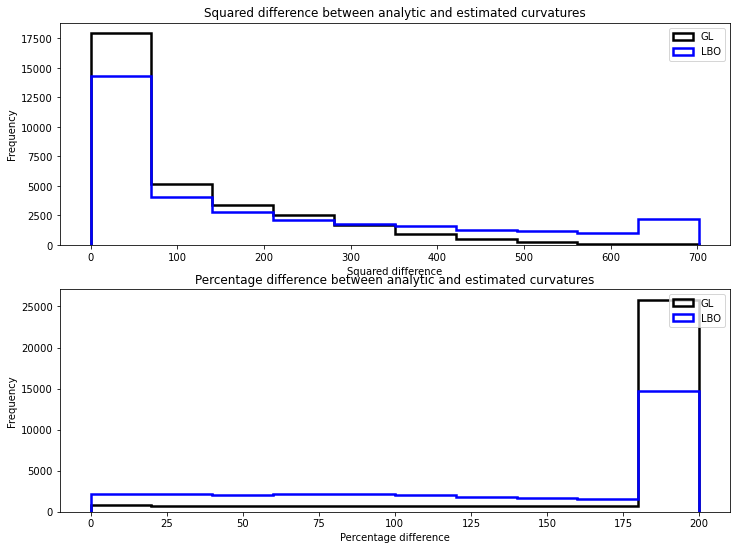

In [603]:
# show histograms of squared differences
nbins = 10
colours = ('b', 'k')
labels = ('LBO', 'GL')
fig, axs = plt.subplots(2, 1, figsize=(12, 9))
for ax, metric, (diff_lbo, diff_gl) in zip(
                    axs, 
                    ('Squared difference', 'Percentage difference'),
                    ((clipped_sq_diff_lbo, clipped_sq_diff_gl), (clipped_perc_diff_lbo, clipped_perc_diff_gl))):
    ax.hist((diff_lbo, diff_gl), nbins, color=colours, label=labels, histtype='step', stacked=False, fill=False, linewidth=2.5)
    ax.set_xlabel(metric)
    ax.set_ylabel("Frequency")
    ax.set_title(f"{metric} between analytic and estimated curvatures")
    ax.legend(loc=1)

In [604]:
# print mean squared error and ssim
mean_sq_err_lbo = sq_diff_lbo.mean()
mean_sq_err_gl = sq_diff_gl.mean()

ssim_lbo = ssim(an_curv, lbo_u, data_range=curv_max - curv_min)
ssim_gl = ssim(an_curv, gl_u, data_range=curv_max - curv_min)

print(f"Mean squared error using LBO = {mean_sq_err_lbo}")
print(f"Mean squared error using GL = {mean_sq_err_gl}")

print(f"SSIM using LBO = {ssim_lbo}")
print(f"SSIM using GL = {ssim_gl}")

Mean squared error using LBO = 198.2261505126953
Mean squared error using GL = 104.62318741886595
SSIM using LBO = 0.08196170282642543
SSIM using GL = 0.319296592195241
